## High-z galaxies with Te measurements

# Determine metallicities using the direct method

In [1]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table


## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

#Probably there is a smart way of doing this with PyNeb
super_wav = {
    'OIII1661': 1661,
    'OIII1666': 1666,
    'NIII1750': 1750,
    'CIII1907': 1907,
    'CIII1909': 1909,
    'NeIII3869': 3869,
    'OII3727': 3727,
    'OII3729': 3729,
    'OIITot': 3729,
    'Hd': 4102,
    'Hg': 4340,
    'OIII4363': 4363,
    'Hb': 4861,
    'OIII4959': 4959,
    'OIII5007': 5007,
    'Ha': 6563,
    'NII6584': 6584
    }

# Quick look at all fluxes

In [3]:
# Load data
fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
fluxes.show_in_notebook()

idx,Name,E(B-V),eE(B-V),OIII1661,OIII1666,NIII1750,CIII1907,CIII1909,NeIII3869,OII3727,OII3729,OIITot,Hd,Hg,OIII4363,Hb,OIII4959,OIII5007,Ha,NII6584,eOIII1661,eOIII1666,eNIII1750,eCIII1907,eCIII1909,eNeIII3869,eOII3727,eOII3729,eOIITot,eHd,eHg,eOIII4363,eHb,eOIII4959,eOIII5007,eHa,eNII6584
0,CSWA20,0.0,0.13247200022161826,0.10801148949368285,0.2699067465793643,nan,0.33799373982063846,0.31018769557612796,0.736208932118781,0.9484312431248809,1.0491374537682203,0.9482588524443528,nan,1.0681617592671107,0.09340146494185268,1.749616644484641,2.8883931010953807,8.549336705827779,5.019639285718948,0.09058351952788013,0.9408383190742072,0.427109216382678,nan,0.23372600153740655,0.23613747604342056,0.21908331321341865,0.21729033618839477,0.22055896709344225,0.4654672057178893,nan,0.2262188816802079,0.6233896989799431,0.21557367633103847,0.21169508502258905,0.2108349431901003,0.19798290283589634,0.3798414923789691
1,Abell_860_359,0.0,0.04078439086020389,0.04422338133454339,0.12230455290232245,0.04399947612101006,nan,nan,nan,nan,nan,1.5321118676085181,nan,nan,nan,1.211251385137438,2.4488264916205567,7.368459112801188,3.4174131322437806,nan,nan,0.3304222588099122,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.08256703698318373,0.07785007222987557,0.07784815546059799,0.06871448949235158,nan
2,Abell_22.3,0.0,0.27042353174449435,nan,nan,nan,nan,nan,nan,nan,nan,4.8647766053831845,nan,nan,1.010293867918788,3.2638648485049924,6.308613821665849,20.31812119562818,12.087348456963715,0.11978176045019676,nan,nan,nan,nan,nan,nan,nan,nan,0.4010948307283845,nan,nan,0.47643196441891617,0.32849973786176295,0.34744937419076133,0.31749842333843176,0.32351891187069853,nan
3,RCSGA,0.09158415054219551,0.25527902959685295,nan,nan,nan,nan,nan,28.35427021373409,nan,nan,269.0056063680285,24.456874591106168,43.73875091952345,4.830655730192015,92.1905879379414,137.26311483221824,438.17478236526136,250.75772223975062,15.952773693759084,nan,nan,nan,nan,nan,0.34034529613950165,nan,nan,0.3028169678718737,0.37755305946562595,0.33568187551207535,nan,0.30813361609054657,0.3079400765931382,0.3064589520438399,0.3002575028858883,0.3385004444409592
4,A1689_31.1,0.21324389418526762,0.2964369659930406,27.67013130795074,63.931661310662975,nan,45.125198793972736,87.61043373585221,29.667520648575312,43.934158091023605,55.85155787055294,99.76902217902192,nan,69.17693804447265,25.053984207882653,149.3503615925536,214.81278824882207,712.530480273644,nan,nan,0.30112270389330514,0.28134025778673644,nan,0.2812946303775021,0.2729113537328961,0.4939249104606339,0.3242755116076593,0.32188443760390933,0.32291128281458514,nan,0.34275180218330753,0.42883951624407823,0.345252232340228,0.3665207144364004,0.3284498070931226,nan,nan
5,SMACS_0304,0.20798736876763335,0.21814114560074005,0.06343743433231225,0.10415885309175886,nan,nan,nan,0.8852958529787464,2.6397367429530103,3.5396166500253523,6.329355385774217,0.7276431784992015,1.1103073512272497,nan,2.422423334413502,3.185932773703164,11.12146102864523,6.9484764140060165,0.2231309000142321,0.33999741155840313,0.31841039663885295,nan,nan,nan,12.521026568021837,3.842106841707224,3.2891344525815827,0.2828994338681158,0.28387605231868773,0.2833496563728977,nan,0.2821087100543067,0.2817360590586997,0.2815236596848161,0.2721432284813631,0.2753334795481129
6,MACS_0451,0.0,0.015485157796039177,0.2535556815748747,0.3799441120565891,0.12460496371881823,nan,nan,nan,nan,nan,0.6722196808704339,nan,nan,nan,1.042915696553581,1.4269619383444279,4.111756827567228,2.6504385259113556,0.06676654037673974,0.1,0.1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.1,0.05,0.05,0.16,nan
7,COSMOS_12805,0.29310244509473643,0.1362016833517219,0.053528224547632404,0.0818993926312767,0.04558991599687093,nan,nan,nan,nan,nan,2.970345216074836,nan,nan,nan,1.0157256286941314,1.9188169504821613,6.5570456802406945,2.8686841813356625,0.10100549433025592,0.012,0.015,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.3,0.42,0.29,0.05,nan
8,BX660,0.0,0.08733699424703631,0.0,0.23398566416107966,nan,nan,nan,

## Using PyNeb/Izotov2006

In [4]:
## Temperatures from Izotov 2009
def Izotov06_TOIII(f,t):
    """ Equation 1 of Izotov 2006. Only works if OIII4663 is seen. Neglecting density.
    """
    t *= 1e-4
    CT = 8.44 - 1.09*t + 0.5*t**2 - 0.08*t**3 # Here we are neglecting the density
    new_t = 1.432 /(np.log10((f['OIII4959'] + f['OIII5007'])/f['OIII4363']) - np.log10(CT))
    return new_t * 1e4

def calculate_TOIII(f):
    
    params = Parameters()
    params.add('t', value=10000., min=1000., max=30000.)
    
    def fnc(params,f):
        t = params['t']
        return t - Izotov06_TOIII(f,t)
    
    fit = minimize(fnc, params,args=(f,),method='least_squares')
    
    return fit.params['t'].value
    
    
def Izotov06_TOII(tOIII,Z='intermediate'):
    """Equation 14 of Izotov 2006. The dispersion of this relation is not provided
    """
    tOIII *= 1e-4 
    if Z == 'low': # 7.2
        return (-0.577 + tOIII * (2.065 - 0.498*tOIII))*1e4 
    elif Z == 'intermediate': #7.6
         return (-0.744 + tOIII * (2.338 - 0.610*tOIII))*1e4 
    elif Z == 'high': # 8.2
        return (2.967 + tOIII * (-4.797 + 2.827*tOIII))*1e4 
    else:
        print('Wrong "Z" option')

In [6]:
# Calculate metallicities
import pyneb as pn
pn.atomicData.setDataFile('o_iii_coll_AK99.dat') # have to change because the default ones do not have level 6
O3 = pn.Atom('O', 3)
O2 = pn.Atom('O',2)

dered_fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
Te_data = Table.read('data_Te.dat',format='ascii.fixed_width_two_line')
Te_data.add_index('Name')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []

def sum_met(OH,O2H):
    return 12 + np.log10(10**(OH-12)+10**(O2H-12))

for f in dered_fluxes[1:2]:
    
    Te = Te_data.loc[f['Name']]['Te'] ## T(OIII)
    Den = Te_data.loc[f['Name']]['Den']
    
    #  Calculate TOII. take our estimated temperatures as TOIII.
    t_low = (Izotov06_TOII(Te,Z='low')) # May need to change the Z
    t_inter = (Izotov06_TOII(Te,Z='intermediate')) # May need to change the Z
    t_high = (Izotov06_TOII(Te,Z='high')) # May need to change the Z

    def change_scale(x):
        return 12+np.log10(x)
    
    # Calculate metalliticites
    O2_H_pyneb.append(change_scale(O3.getIonAbundance((f['OIII4959']+f['OIII5007']),Te,Den,
                                                to_eval='L(4959)+L(5007)',Hbeta=f['Hb'])))
    
    O_H_pyneb.append(change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den,
                                                     to_eval='L(3726)+L(3729)',Hbeta=f['Hb'])))
    
    met_pyneb.append(sum_met(O2_H_pyneb[-1],O_H_pyneb[-1]))
    
    a = change_scale(O2.getIonAbundance((f['OIITot']),t_low,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    b = change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    c = change_scale(O2.getIonAbundance((f['OIITot']),t_high,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    #print(a,b,c)
    
    
#print('                Name\tO/H\tO+2/H\tMetOH')
#for i,f in enumerate(dered_fluxes):
#    print('%20s\t%0.2f\t%0.2f\t%0.2f'%(f['Name'],O_H_pyneb[i],O2_H_pyneb[i],met_pyneb[i]))


## Calculate Errors

In [7]:
def change_scale(x):
    return 12+np.log10(x)


def perturbed_lines(f,nb):
    np.random.seed()
    new_lines = {}
    for line in ['OIII4959',"OIII5007","OIITot",'Hb']:
        if np.isfinite(f[line]) and np.isfinite(f['e'+line]):
            new_lines[line] = np.random.normal(f[line],f['e'+line],nb)
        else:
            new_lines[line] = [f[line]] * nb

    return new_lines


In [8]:
# Calculate metallicities with error estimation
from astropy.visualization import hist
import pickle
galaxies = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []
upO_H_pyneb = []
upO2_H_pyneb = []
upmet_pyneb = []
lowO_H_pyneb = []
lowO2_H_pyneb = []
lowmet_pyneb = []

nb = 500

print('                Name\t       O/H\t\t       O+2/H\t\t      MetOH')
for gal in galaxies:
    
    O2_H_sample = []
    O_H_sample = []
    
    #  Sample of fluxes, densitties and TOIII. Calculate TOII
    dered_f = perturbed_lines(gal,nb)
    tem_and_den    = pickle.load( open( 'tem_and_ebv_samples/'+gal['Name']+"_tem_and_ebv.pickle", "rb" ) )
    tOIII_sample  = np.random.choice(tem_and_den['tem'], nb)#np.full_like(dered_f['Hb'],gal['Te'])
    den_sample    = np.random.choice(tem_and_den['den'], nb)#np.full_like(dered_f['Hb'],gal['Den'])  
    tOII_sample   = np.array([Izotov06_TOII(x,Z='low') for x in tOIII_sample]) # May need to change the Z
    
    ## Calculate metalliticites
    O2_H_sample.append(O3.getIonAbundance(np.array(dered_f['OIII4959'])+np.array(dered_f['OIII5007']),
                                          tOIII_sample,den_sample,to_eval='L(4959)+L(5007)',Hbeta=dered_f['Hb']))
    O_H_sample.append(O2.getIonAbundance(np.array(dered_f['OIITot']),
                                          tOII_sample,den_sample,
                                          to_eval='L(3726)+L(3729)',Hbeta=dered_f['Hb']))
    
    total = np.array([change_scale(m1+m2) for  m1,m2 in zip(O2_H_sample,O_H_sample)])
    O2_H_sample = np.array([change_scale(m) for  m in O2_H_sample])
    O_H_sample  = np.array([change_scale(m) for  m in O_H_sample])
    
    O2_H_pyneb.append(np.nanpercentile(O2_H_sample,50))
    O_H_pyneb.append(np.nanpercentile(O_H_sample,50)) 
    upO2_H_pyneb.append(np.nanpercentile(O2_H_sample,84)-np.nanpercentile(O2_H_sample,50))
    upO_H_pyneb.append(np.nanpercentile(O_H_sample,84)-np.nanpercentile(O_H_sample,50))
    lowO2_H_pyneb.append(np.nanpercentile(O2_H_sample,50)-np.nanpercentile(O2_H_sample,16))
    lowO_H_pyneb.append(np.nanpercentile(O_H_sample,50)-np.nanpercentile(O_H_sample,16))
    met_pyneb.append(np.nanpercentile(total,50))
    upmet_pyneb.append(np.nanpercentile(total,84)-np.nanpercentile(total,50))
    lowmet_pyneb.append(np.nanpercentile(total,50)-np.nanpercentile(total,16))

    print('%20s\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f'%(gal['Name'],
                                                               O_H_pyneb[-1],upO_H_pyneb[-1],lowO_H_pyneb[-1],
                                                               O2_H_pyneb[-1],upO2_H_pyneb[-1],lowO2_H_pyneb[-1],
                                                              met_pyneb[-1],upmet_pyneb[-1],lowmet_pyneb[-1]))


                Name	       O/H		       O+2/H		      MetOH
              CSWA20	7.04 + 0.54 - 0.35	7.99 + 0.39 - 0.23	8.04 + 0.40 - 0.24
       Abell_860_359	7.28 + 0.14 - 0.09	8.01 + 0.13 - 0.09	8.09 + 0.13 - 0.09
          Abell_22.3	7.18 + 0.38 - 0.12	7.36 + 0.17 - 0.10	7.60 + 0.09 - 0.06
               RCSGA	7.74 + 0.03 - 0.03	7.98 + 0.02 - 0.03	8.18 + 0.03 - 0.03
          A1689_31.1	6.73 + 0.13 - 0.03	7.41 + 0.18 - 0.16	7.48 + 0.16 - 0.10
          SMACS_0304	7.86 + 0.24 - 0.12	8.02 + 0.08 - 0.07	8.26 + 0.13 - 0.09
           MACS_0451	6.70 + 0.07 - 0.05	7.34 + 0.14 - 0.11	7.43 + 0.12 - 0.09
        COSMOS_12805	7.67 + 0.18 - 0.17	8.03 + 0.17 - 0.20	8.19 + 0.18 - 0.19
               BX660	6.91 + 0.10 - 0.09	7.83 + 0.11 - 0.15	7.87 + 0.11 - 0.14
                BX74	7.13 + 0.18 - 0.18	8.00 + 0.17 - 0.28	8.06 + 0.17 - 0.27
               BX418	7.00 + 0.14 - 0.13	7.87 + 0.17 - 0.18	7.92 + 0.16 - 0.17
           S16-stack	7.74 + 0.06 - 0.07	7.94 + 0.06 - 0.07	8.15 + 0.06 - 0.07
     

In [9]:
## Save results in a table 
pyneb_out = Table([galaxies['Name'],
                   O_H_pyneb,upO_H_pyneb,lowO_H_pyneb,
                   O2_H_pyneb,upO2_H_pyneb,lowO2_H_pyneb,
                   met_pyneb,upmet_pyneb,lowmet_pyneb],
                names = ['Name','O/H','upO/H','lowO/H','O2/H','upO2/H','lowO2/H','met','upmet','lowmet'])

pyneb_out.write('direct_metallicity.dat',format='ascii.fixed_width_two_line')
pyneb_out.show_in_notebook() 

idx,Name,O/H,upO/H,lowO/H,O2/H,upO2/H,lowO2/H,met,upmet,lowmet
0,CSWA20,7.043343799927754,0.5395643608523129,0.3482934955664989,7.993087140450721,0.38585646613007807,0.22859044276899265,8.040682520975487,0.39697653796206644,0.23557209302221516
1,Abell_860_359,7.284560681627126,0.13924754358526137,0.0885290276289803,8.010842526659742,0.12840348125813783,0.09320354641147954,8.085681423249918,0.13050271199635688,0.09215803488842234
2,Abell_22.3,7.178239202892905,0.37528730353180073,0.12340649913607482,7.3646762332996865,0.17029780882524115,0.09775863287593989,7.601290243744051,0.08699061457671053,0.06134848697064754
3,RCSGA,7.7435002554948245,0.026906152120603544,0.030069099493719165,7.984799836832594,0.024698160310618,0.02721933096370499,8.181767377547924,0.02536058594261803,0.028281145200386604
4,A1689_31.1,6.732235174176695,0.12988796340236153,0.02773594517787359,7.405581375671155,0.1798233564226388,0.16131802759135372,7.484996408196459,0.1611965102851709,0.09844233415433656
5,SMACS_0304,7.863170224711867,0.23847198511424317,0.12493062309854963,8.022871241395684,0.07992502025002146,0.07342865154295097,8.262346436041934,0.12616486101441282,0.09007753567758314
6,MACS_0451,6.70380474958124,0.06680634298679333,0.05150625337623893,7.341994023927003,0.13863939862751362,0.10697540622804613,7.429876189998506,0.12282987044621585,0.08579419329285187
7,COSMOS_12805,7.670150964950439,0.1815821364323016,0.1710534329769251,8.03420090827079,0.1747718659684523,0.20092365645863097,8.19136144961457,0.18059475182314344,0.19415915746877221
8,BX660,6.913884288436021,0.09543241668379032,0.09435211791620368,7.827570987555397,0.10942323002689225,0.15482413206671453,7.8745931424272175,0.10896705502730608,0.14151505696136724
9,BX74,7.1308004474403255,0.1779096365041113,0.18406598965174226,8.000038505761387,0.16961377067951844,0.28440163850875866,8.055324514807847,0.16995457728687668,0.2734866646690035


In [11]:
## Write it to paper 
sample = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line') # just to get the right order
Te = Table.read('data_Te.dat',format='ascii.fixed_width_two_line')
Te.add_index('Name')
Met = Table.read('direct_metallicity.dat',format='ascii.fixed_width_two_line')
Met.add_index('Name')

diag = ['b,c','a,c','a','b','b,c','a,c','b','a','a','a','a','a,c','b,c','a,d','a,c','a,c']
    
out = open('TeMet_for_paper','w')
out.write('Object & Diag. & \Te & \Ne & \ext & 12+log(O$^+$/H$^+$) & 12+log(O$^{2+}$/H$^+$) & 12+log(O/H)$_{(Te)}$ \n')
          
for gal,d in zip(sample,diag):
    m = Te.loc[gal['Name']]
    out.write('%s\t&%s\t&'%(m['Name'],d))
    out.write('%d$^{+%d}_{-%d}$\t&'%(m['Te'],m['upTe']-m['Te'],m['Te']-m['lowTe']))
    out.write('%d$^{+%d}_{-%d}$\t&'%(m['Den'],m['upDen']-m['Den'],m['Den']-m['lowDen']))
    out.write('%0.2f$^{+%0.2f}_{-%0.2f}$\t &'%(m['EBV'],m['upEBV']-m['EBV'],m['EBV']-m['lowEBV']))

    t = Met.loc[gal['Name']]
    out.write('%0.2f$^{+%0.2f}_{-%0.2f}$\t &'%(t['O/H'],t['upO/H'],t['lowO/H']))  
    out.write('%0.2f$^{+%0.2f}_{-%0.2f}$\t &'%(t['O2/H'],t['upO2/H'],t['lowO2/H']))   
    out.write('%0.2f$^{+%0.2f}_{-%0.2f}$\t '%(t['met'],t['upmet'],t['lowmet']))  
    out.write('\\\\ \n')
                    
out.close()

<IPython.core.display.Javascript object>


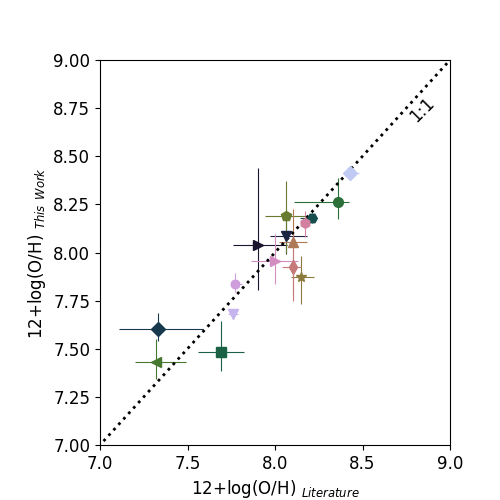

(0.10812204548982157, 0.08317442097249465)
(0.018127884020932683, 0.2754068575727828)


In [12]:
# Compare with previous estimations
plt.rcParams.update({'font.size': 12})
galaxies = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line')
Te = Table.read('direct_metallicity.dat',format='ascii.fixed_width_two_line')
Te.add_index('Name')

## colors and markers
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(galaxies['Name'])))

#plotting
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.2)
diff = []

for gal in galaxies: 
    met = Te.loc[gal['Name']]
    diff.append(np.abs(gal['MetTe']-met['met']))
    ax.errorbar(gal['MetTe'],met['met'],label=gal['Name'],
                xerr=np.array((np.abs(gal['infMetTe']),gal['supMetTe'])).reshape(2,1),
                yerr=np.array((met['lowmet'],met['upmet'])).reshape(2,1),
                color=colors[gal['nb']],marker=gal['marker'],
                markersize=7,elinewidth=0.8)

ax.plot(np.arange(6.0,10.),np.arange(6.0,10.),color='k',linewidth=2.0,linestyle=':')
#ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)+0.5,color='k',linewidth=0.7,linestyle=':')
#ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)-0.5,color='k',linewidth=0.7,linestyle=':')
ax.set_ylabel('12+log(O/H) $_{This\,\,\,Work}$')
ax.set_xlabel('12+log(O/H) $_{Literature}$')
ax.set_ylim(7.0,9.0)
ax.set_xlim(7.0,9.0)
ax.annotate('1:1',xy=(8.75,8.75),rotation=45)

print(np.mean(diff),np.std(diff))
print(np.min(diff),np.max(diff))

fig.savefig('/Users/vera/Desktop/DirectMethod_Lit.pdf')